## Part 1: EDA

_Insert cells as needed below to write a short EDA/data section that summarizes the data for someone who has never opened it before._ 
- Answer essential questions about the dataset (observation units, time period, sample size, many of the questions above) 
- Note any issues you have with the data (variable X has problem Y that needs to get addressed before using it in regressions or a prediction model because Z)
- Present any visual results you think are interesting or important

In [1]:
import pandas as pd
from statsmodels.formula.api import ols as sm_ols
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col # nicer tables
import os

In [2]:
housing_df = pd.read_csv('./input_data2/housing_train.csv')  

## Data Analysis Summary
   - **Unit of Observations**: Parcels of land
   - **Unit of Measurement**: v_SalePrice - Sale Price of parcel
   - **Range of Dates**: January 2006 through December 2008
   - **Number of Observations**: 1941
   - **Continous Variables**: (Not a complete list): v_SalePrice, v_Lot_Area, v_Lot_Frontage
   - **Discrete Variables**: (Not a complete list): v_Yr_Sold, v_Yr_Built, v_Mo_Sold
   - **Categorical Variables**: (Not a complete list): v_Sale_Condition, v_MS_SubClass, v_Sale_Type
   
## Errors within the Data
Many variables had missing values which has to do with the type of land parcel and the attributes within each parcel type. An example of this is how there are different parcel types which mean that not every property will have a basement, or multiple bathrooms and bedrooms. This difference has left a few NaN values within the data set which will ultimately effect the values of the regression analysis. The missing values will most effect the categorical variables that are looked over. 
   

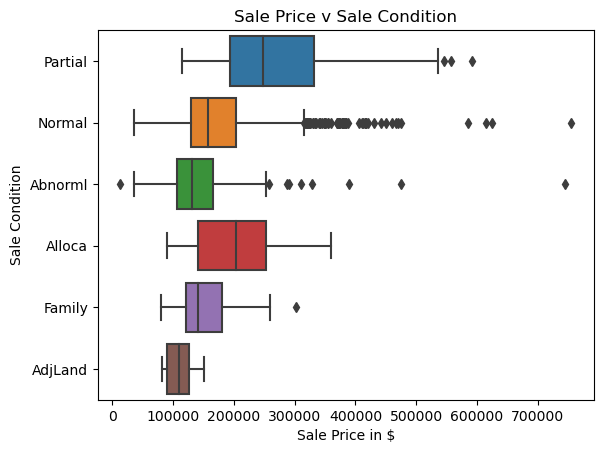

In [3]:
box1 = sns.boxplot(data=housing_df, x="v_SalePrice", y="v_Sale_Condition").set(xlabel = 'Sale Price in $', ylabel = 'Sale Condition',title='Sale Price v Sale Condition')

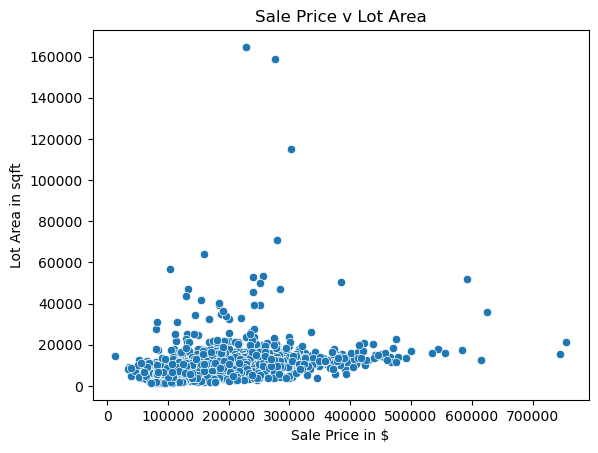

In [4]:
scatter1 = sns.scatterplot(data=housing_df, x="v_SalePrice", y="v_Lot_Area").set(xlabel = 'Sale Price in $', ylabel = 'Lot Area in sqft',title='Sale Price v Lot Area')

## Part 2: Running Regressions

**Run these regressions on the RAW data, even if you found data issues that you think should be addressed.**

_Insert cells as needed below to run these regressions. Note that $i$ is indexing a given house, and $t$ indexes the year of sale._ 

1. $\text{Sale Price}_{i,t} = \alpha + \beta_1 * \text{v_Lot_Area}$
1. $\text{Sale Price}_{i,t} = \alpha + \beta_1 * log(\text{v_Lot_Area})$
1. $log(\text{Sale Price}_{i,t}) = \alpha + \beta_1 * \text{v_Lot_Area}$
1. $log(\text{Sale Price}_{i,t}) = \alpha + \beta_1 * log(\text{v_Lot_Area})$
1. $log(\text{Sale Price}_{i,t}) = \alpha + \beta_1 * \text{v_Yr_Sold}$
1. $log(\text{Sale Price}_{i,t}) = \alpha + \beta_1 * (\text{v_Yr_Sold==2007})+ \beta_2 * (\text{v_Yr_Sold==2008})$
1. Choose your own adventure: Pick any five variables from the dataset that you think will generate good R2. Use them in a regression of $log(\text{Sale Price}_{i,t})$ 
    - Tip: You can transform/create these five variables however you want, even if it creates extra variables. For example: I'd count Model 6 above as only using one variable: `v_Yr_Sold`.
    - I got an R2 of 0.877 with just "5" variables. How close can you get? I won't be shocked if someone beats that!
    

**Bonus formatting trick:** Instead of reporting all regressions separately, report all seven regressions in a _single_ table using `summary_col`.


In [5]:
housing_df = (housing_df
            # .assign(saleP_LotArea = housing_df['v_Lot_Area']) 
            .assign(l_LotArea = np.log(housing_df['v_Lot_Area'])) 
            .assign(l_SalePrice = np.log(housing_df['v_SalePrice'])) 
            .assign(l_Overall_Condition = np.log(housing_df['v_Overall_Cond'])) 
            .assign(l_Gr_Live_Area = np.log(housing_df['v_Gr_Liv_Area'])) 
            .assign(const = 1)                           
            )  

In [6]:
# fit the two regressions, and save these as objects (containing the results)
res1 = sm_ols('v_SalePrice ~ v_Lot_Area', data=housing_df).fit()
res2 = sm_ols('v_SalePrice ~ l_LotArea', data=housing_df).fit()
res3 = sm_ols('l_SalePrice ~ v_Lot_Area', data=housing_df).fit()
res4 = sm_ols('l_SalePrice ~ l_LotArea', data=housing_df).fit()
res5 = sm_ols('l_SalePrice ~ v_Yr_Sold', data=housing_df).fit()
res6 = sm_ols('l_SalePrice ~ (v_Yr_Sold == 2007) + (v_Yr_Sold == 2008)', data=housing_df).fit()
# Model 7 includes, log Sales Price v (log overall condition, overall condition, log garage living area, garage area, year built)
res7 = sm_ols('l_SalePrice ~ l_Overall_Condition + v_Overall_Cond + l_Gr_Live_Area + v_Garage_Area + v_Year_Built', data=housing_df).fit()

# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

# This summary col function combines a bunch of regressions into one nice table
summary = summary_col(results=[res1,res2,res3,res4,res5,res6,res7],
                    float_format='%0.2f',
                    stars = True,
                    model_names=['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6', 'Model 7'],
                    info_dict=info_dict,
                    regressor_order=['Intercept','v_Lot_Area','l_LotArea','l_lot','v_Yr_Sold','C(v_Yr_Sold)[T.2007]','C(v_Yr_Sold)[T.2008]']
                   )
summary.add_title('Regressions of Sale Prices')
print(summary)

                                  Regressions of Sale Prices
                            Model 1       Model 2    Model 3  Model 4 Model 5 Model 6  Model 7 
-----------------------------------------------------------------------------------------------
Intercept                 154789.55*** -327915.80*** 11.89*** 9.41*** 22.29   12.02*** -4.80***
                          (2911.59)    (30221.35)    (0.01)   (0.15)  (22.94) (0.02)   (0.36)  
v_Lot_Area                2.65***                    0.00***                                   
                          (0.23)                     (0.00)                                    
l_LotArea                              56028.17***            0.29***                          
                                       (3315.14)              (0.02)                           
v_Yr_Sold                                                             -0.01                    
                                                                      (0.01

In [7]:
# Mean log sale prices vs Sale price for each year(2006, 2007, 2008)
# This table is used for some of the questions below
housing_df.groupby('v_Yr_Sold')[['l_SalePrice','v_SalePrice']].mean()

,l_SalePrice,v_SalePrice
v_Yr_Sold,,
2006,12.022869,181761.648000
2007,12.048460,185138.207493
2008,12.012588,178841.750804


## Part 3: Regression interpretation

_Insert cells as needed below to answer these questions. Note that $i$ is indexing a given house, and $t$ indexes the year of sale._ 

1. If you didn't use the `summary_col` trick, list $\beta_1$ for Models 1-6 to make it easier on your graders.
1. Interpret $\beta_1$ in Model 2.  
1. Interpret $\beta_1$ in Model 3. 
1. Of models 1-4, which do you think best explains the data and why?
1. Interpret $\beta_1$ In Model 5
1. Interpret $\alpha$ in Model 6
1. Interpret $\beta_1$ in Model 6
1. Why is the R2 of Model 6 higher than the R2 of Model 5?
1. What variables did you include in Model 7?
1. What is the R2 of your Model 7?
1. Speculate (not graded): Could you use the specification of Model 6 in a predictive regression? 
1. Speculate (not graded): Could you use the specification of Model 5 in a predictive regression? 


### Part 3: Regression Answers

1. Used summary_col, Noted Above
2. Beta in model 2 indicates that a 1% increase in the lot size can be associated with a sales price that is $560 higher  
3. Beta in model 3 indicates that an increase of 1 sqft in lot size can be associated with a sales price that is 0.0013% greater. 
4. I believe that model 4 explains the data the best because it has the highest R-squared and R-squared adjusted values. Although the model seems to have the same values as model 2, after printing more decimal places for each, I determined that model 4 was greater. 
5. Beta in model 5 indicates that an increase of 1 unit a year can be associated with 0.5% lower sale prices.
6. Alpha in model 6 indicates that the average log price in 2006 was 12.02(intercept)
7. Beta in model 6 indicates that the average log price was greater in 2007 than 2006 by 0.03 or 3%
8. The R2 of model 6 is greater than that in model 5 because model 6 is more flexible in determining the average price over time. In model 5 that average is determined by a strict slope while in model 6 it can be determined by multiple averages in a sequence
9. In Model 7 I included the following variables: Log(overall condition), overall condition, Log(garage living area), garage area, year built
10. R2 of model 7 is 0.79
11. Using model 6 as a predictive model would not be very effective as we have no data regarding the following year of 2009, so how could we predict sales and average prices. 
12. I believe we can use model 5 as a predictive model because we can predict a log of a future sale and average price. 